# Personality Prediction with PCA
In this notebook, we use the Myers Briggs Type Indicator (MBTI) dataset to predict personality traits using PCA. The dataset contains 1000 rows and 2 columns. The first column contains the personality type and the second column contains the posts. We use PCA to reduce the dimensionality of the extracted data features and then use a classifier to predict the personality traits.

This Jupyter Notebook demonstrates the implementation of our work. It contains data wrangling, sentence embedding, dimensionality reduction, classification, and visualization. The code cells make use of popular Python libraries such as pandas, scikit-learn, matplotlib, and nltk to perform data manipulation, machine learning, and plotting.

In [27]:
# Plot graphs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  # pip install matplotlib seaborn
import itertools
%matplotlib inline

# Part 1: Data Preprocessing
import numpy as np
import pandas as pd
import os 
import re
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')

# Part 2: Extract Features
from sklearn.feature_extraction.text import TfidfVectorizer  # Text Vectorization
import pandas as pd
import pickle

# Part 3: Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

## Part 4: Classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# ignore warnings
import warnings

[nltk_data] Downloading package wordnet to /home/hb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Part 0: Load the MBTI dataset from csv file

In [28]:
datapath = '../dataset/mbti_1.csv'

## Exploratory Analysis
To begin this exploratory analysis, first use `matplotlib` and define functions for plotting the data.

In [29]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [30]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [31]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [32]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# mbti_1.csv has 8675 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv(datapath, delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'mbti_1.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


Let's take a quick look at what the data looks like:

In [33]:
df1.head(5)

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

Distribution graphs (histogram/bar graph) of sampled columns:

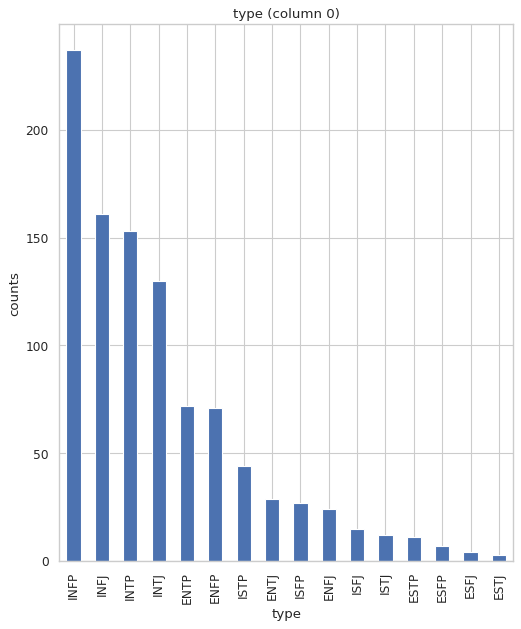

In [36]:
plotPerColumnDistribution(df1, 10, 5)

This show the data is skewed.

# Part 1: Data Wraggling

The data is preprocessed by removing special characters, converting to lowercase, and removing stopwords. The data is then tokenized and lemmatized. The lemmatized data is then converted to a matrix of token counts.

In [37]:
# prompt: data wrggling the text from dataframe
df = df1

# Select the column containing the text you want to wrangle
text_column = 'posts'

# Convert the text column to lowercase
df[text_column] = df[text_column].str.lower()

# Remove special characters
df[text_column] = df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# Remove URLs
df[text_column] = df[text_column].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove punctuation from the text column
df[text_column] = df[text_column].str.replace('[^\w\s]', '')

# Remove stop words from the text column
stop_words = ['a', 'an', 'the', 'in', 'on', 'at', 'of', 'to', 'for', 'by', 'with', 'from', 'and']
df[text_column] = df[text_column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Lemmatize the text column using WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
df[text_column] = df[text_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))



# Print the wrangled text data
print(df[text_column])


0      intj moment sportscenter not top ten play pran...
1      im finding lack me these post very alarmingsex...
2      good one course which i say i know thats my bl...
3      dear intp i enjoyed our conversation other day...
4      youre firedthats another silly misconception t...
                             ...                        
995    a intj i have been very interested estjs reaso...
996    that wa too irresistible lol rofl rly wtf ppl ...
997    hello you look lovelya quick recap general jou...
998    i start every single phone conversation me hey...
999    lol course clearly your name is mike bill bob ...
Name: posts, Length: 1000, dtype: object


# Part 2: Convert Sentence into Vector Space

The next step is to convert the sentences into vector space. We will use the `TfidfVectorizer` from scikit-learn to convert the text data into a matrix of TF-IDF features. The `TfidfVectorizer` will tokenize documents, learn the vocabulary, and inverse document frequency weightings, and allow you to encode new documents.

In [38]:
# Specify the file path for the DataFrame
max_features = 1000  # This can be ignored or repurposed since max_length is specific to BERT
file_path = 'df_mbti_with_tfidf_embedding.pkl'

if os.path.exists(file_path):
    # Read the DataFrame from the file
    with open(file_path, 'rb') as file:
        tfidf_df = pickle.load(file)
else:
    class Lemmatizer(object):
        def __init__(self):
            self.lemmatizer = WordNetLemmatizer()
        def __call__(self, sentence):
            return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english',tokenizer=Lemmatizer())  # You can specify max_features to limit dimensionality

    # Fit and transform the posts to get TF-IDF features
    tfidf_matrix = vectorizer.fit_transform(df['posts'])

    # Convert the TF-IDF matrix to a DataFrame and add to df
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Save the DataFrame into a file for fast access in the future
    with open(file_path, 'wb') as file:
        pickle.dump(tfidf_df, file)

# Now df is ready to use
tfidf_df.head(5)

10  100   20   ability      able     about  above  absolutely  accept  \
0  0.0  0.0  0.0  0.000000  0.000000  0.025398    0.0    0.000000     0.0   
1  0.0  0.0  0.0  0.000000  0.027449  0.026486    0.0    0.000000     0.0   
2  0.0  0.0  0.0  0.095998  0.034440  0.066464    0.0    0.088289     0.0   
3  0.0  0.0  0.0  0.000000  0.058129  0.084134    0.0    0.000000     0.0   
4  0.0  0.0  0.0  0.000000  0.000000  0.030048    0.0    0.000000     0.0   

   accurate  ...  yet       you  youd     youll  young  younger      your  \
0  0.000000  ...  0.0  0.124479   0.0  0.000000    0.0      0.0  0.210844   
1  0.000000  ...  0.0  0.259619   0.0  0.000000    0.0      0.0  0.068710   
2  0.050072  ...  0.0  0.211734   0.0  0.000000    0.0      0.0  0.120696   
3  0.000000  ...  0.0  0.233664   0.0  0.038038    0.0      0.0  0.087305   
4  0.000000  ...  0.0  0.220904   0.0  0.000000    0.0      0.0  0.015590   

      youre  yourself     youve  
0  0.036668  0.000000  0.062718  
1  0.076477  0.025709  0.000000  
2  0.071967  0.000000  0.000000  
3  0.121467  0.000000  0.069253  
4  0.021691  0.000000  0.000000  

[5 rows x 1000 columns]

In [39]:
# Convert the TF-IDF DataFrame to a NumPy array
embeddings_array = tfidf_df.to_numpy()

# Print the numpy array
print(embeddings_array)

# Print the shape of the numpy array
print(embeddings_array.shape)


[[0.         0.         0.         ... 0.03666828 0.         0.06271807]
 [0.         0.         0.         ... 0.07647701 0.02570928 0.        ]
 [0.         0.         0.         ... 0.07196701 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0788545  0.05301705 0.10115561]
 [0.03150437 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(1000, 1000)


## Part 2.2: Apply Methods to Reduce Dimensionality

After extracting embeddings for each text sample, we can apply dimensionality reduction techniques to visualize or cluster the data. Here, we use PCA (Principal Component Analysis), 


In [40]:
# 1. Initialize the dimensionality reduction methods
# key: method name, value: method object

k = 500  # Number of dimensions to reduce to
seed = 42  # Random seed for reproducibility

method_dict = {
    'PCA': PCA(n_components=k, random_state=seed),
    'KernelPCA': KernelPCA(n_components=k, kernel='rbf', random_state=seed),
    'TruncatedSVD/LSI': TruncatedSVD(n_components=k, random_state=seed),
    'TSNE': TSNE(n_components=3, random_state=seed) 
    # n_components=2: t-SNE is set to reduce dimensionality to 2 or 3 because higher dimensions do not effectively leverage t-SNE’s strengths 
    # in capturing local structures in high-dimensional data
}

# 2. Fit and transform the embeddings array using the dimensionality reduction methods
# key: method name, value: reduced embeddings
reduced_embeddings = {
    method : method_dict[method].fit_transform(embeddings_array)
    for method in method_dict
} 

# 3. Print the shape of the reduced embeddings
for method in reduced_embeddings:
    print(f'{method}: {reduced_embeddings[method].shape}')


PCA: (1000, 500)
KernelPCA: (1000, 500)
TruncatedSVD/LSI: (1000, 500)
TSNE: (1000, 3)


### Visualize the MBTI Classes and the Sentences Embedding in 2D

The following code cell visualizes the MBTI classes and the sentences embedding in a 2d graph with all the classes for each dimensionality reduction method.

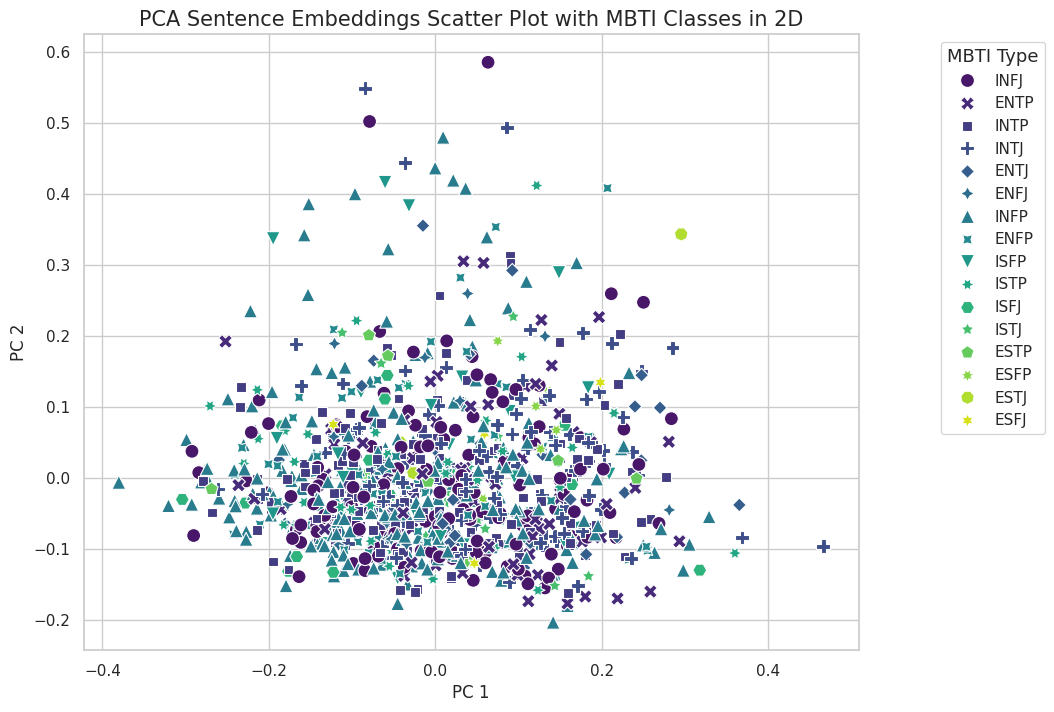

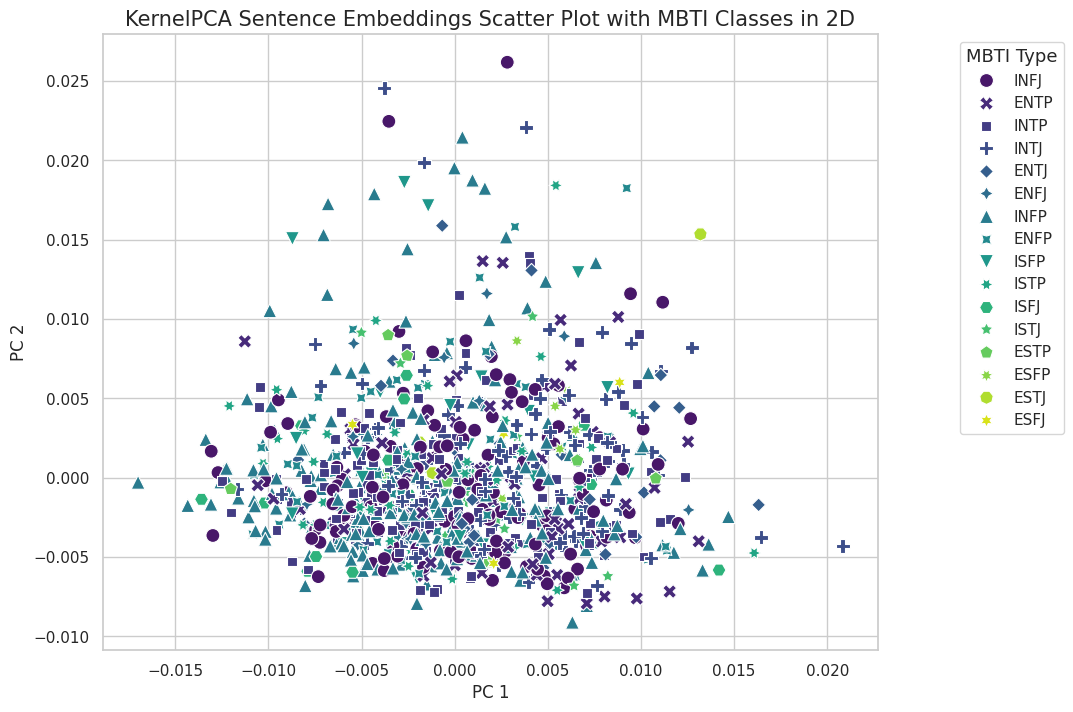

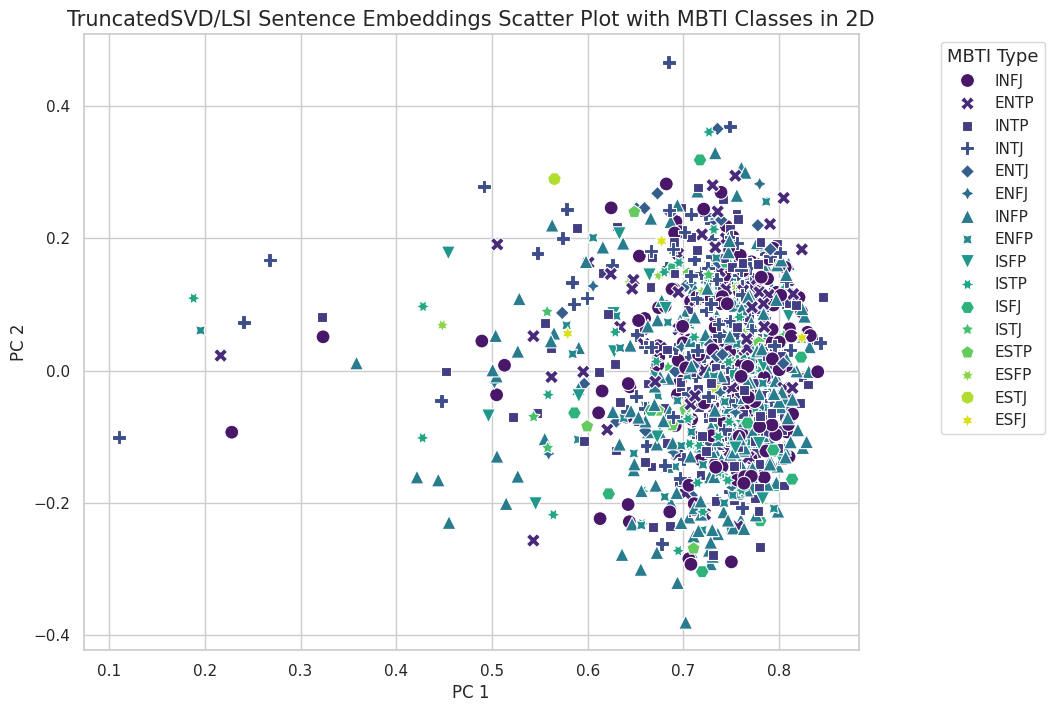

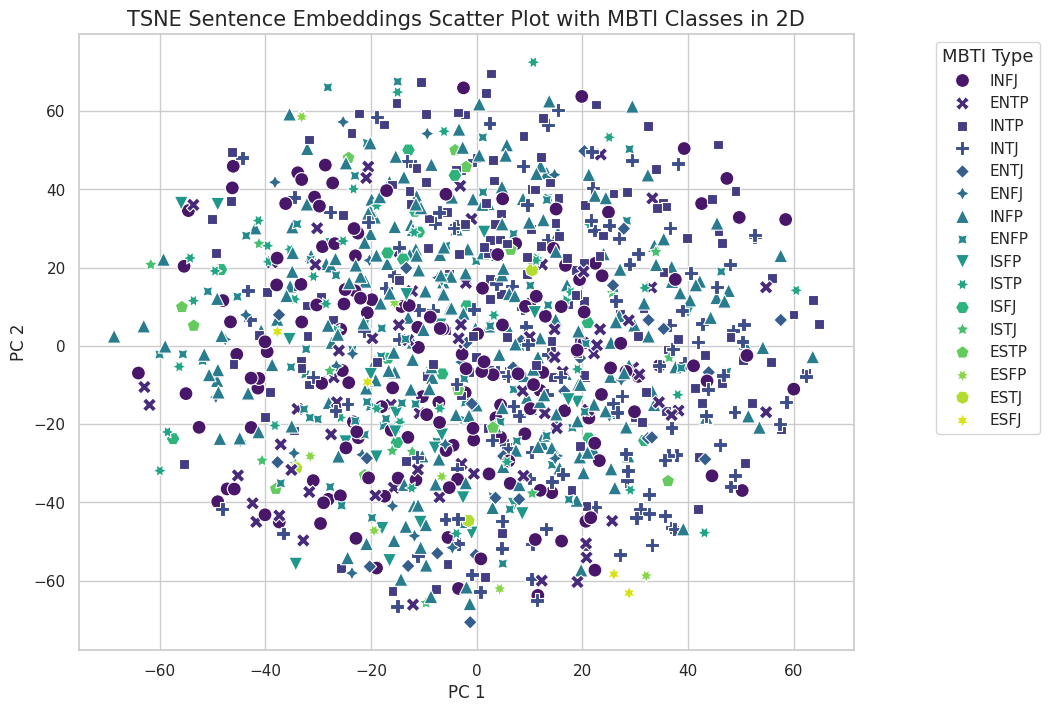

In [41]:
for method in reduced_embeddings:
    # Create a DataFrame with the reduced embeddings
    df = pd.DataFrame(reduced_embeddings[method][:,:2], columns=['pc_one', 'pc_two'])

    # Add the type column to the DataFrame
    df['type'] = df1['type']
    
    
    # Setting the aesthetic style of the plots
    sns.set_theme(style="whitegrid")

    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x='pc_one', y='pc_two', hue='type', data=df, palette='viridis', s=100, style='type', markers=True)

    # Adding titles and labels
    plt.title(f'{method} Sentence Embeddings Scatter Plot with MBTI Classes in 2D', fontsize=15)
    plt.xlabel('PC 1', fontsize=12)
    plt.ylabel('PC 2', fontsize=12)

    # Legend settings
    plt.legend(title='MBTI Type', title_fontsize='13', fontsize='11', loc='upper right', bbox_to_anchor=(1.25, 1))

    # Show the plot
    plt.show()


### Visualize the MBTI Classes and the Sentences Embedding in 3D

The following code cell visualizes the MBTI classes and the sentences embedding in a 3d graph with all the classes for each dimensionality reduction method.

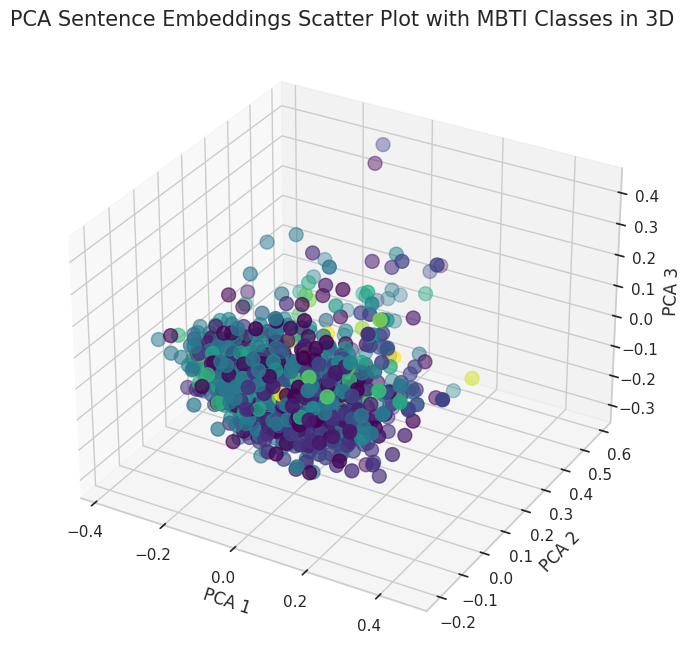

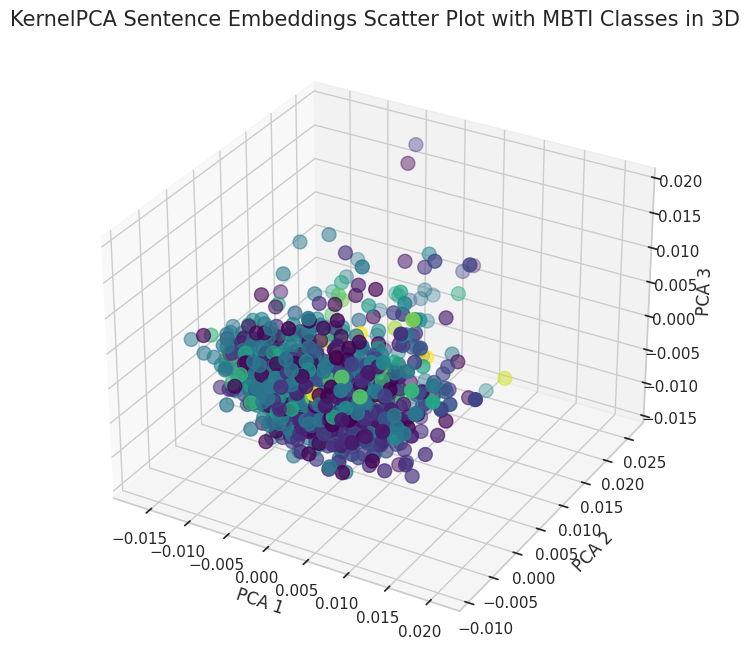

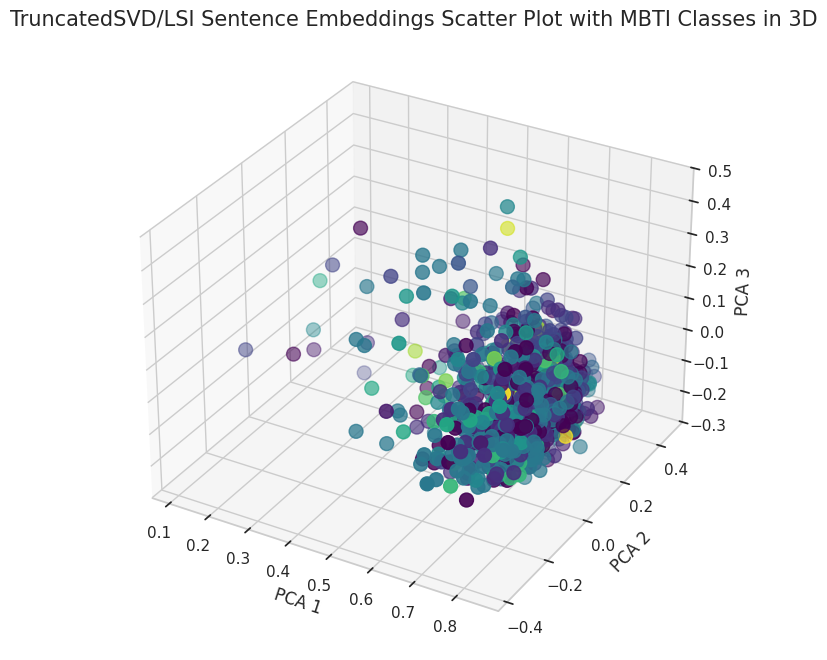

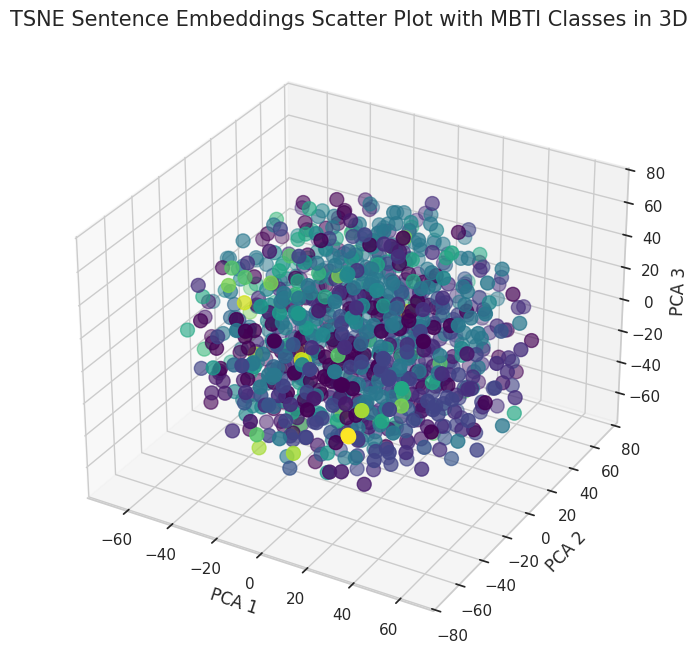

In [42]:
for method in reduced_embeddings:
    # Create a DataFrame with the reduced embeddings
    df = pd.DataFrame(reduced_embeddings[method][:,:3], columns=['pca_one', 'pca_two', 'pca_three'])

    # Add the type column to the DataFrame
    df['type'] = df1['type']


    # Setting the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['pca_one'], df['pca_two'], df['pca_three'], c=pd.factorize(df['type'])[0], cmap='viridis', s=100)

    # Adding titles and labels
    ax.set_title(f'{method} Sentence Embeddings Scatter Plot with MBTI Classes in 3D', fontsize=15)
    ax.set_xlabel('PCA 1', fontsize=12)
    ax.set_ylabel('PCA 2', fontsize=12)
    ax.set_zlabel('PCA 3', fontsize=12)

    # Legend with MBTI types
    # Show the plot
    plt.show()


### Visualize Seleted Pair MBTI Classes and the Sentences Embedding in 2D

The following code cell visualizes the 'ISTJ' and 'ENFP' MBTI classes and the sentences embedding in a 2d graph for each dimensionality reduction method.

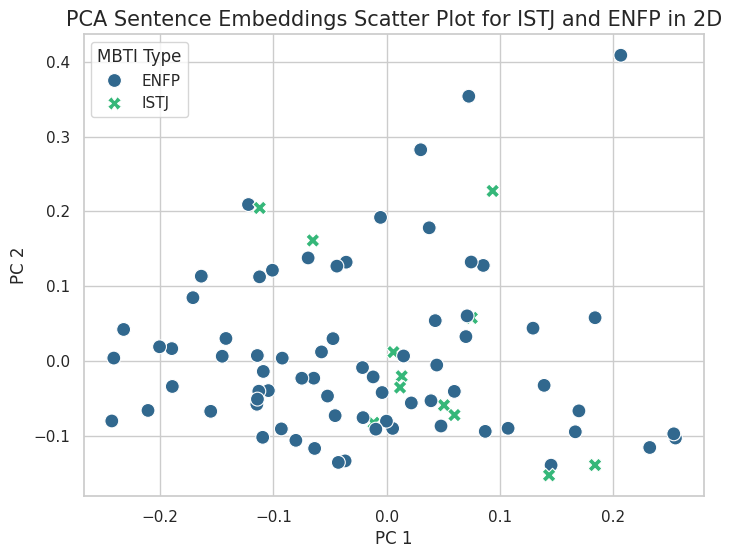

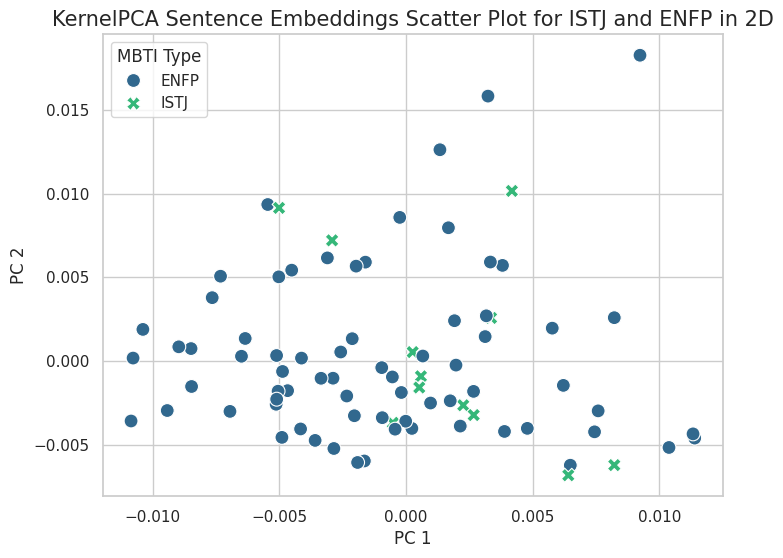

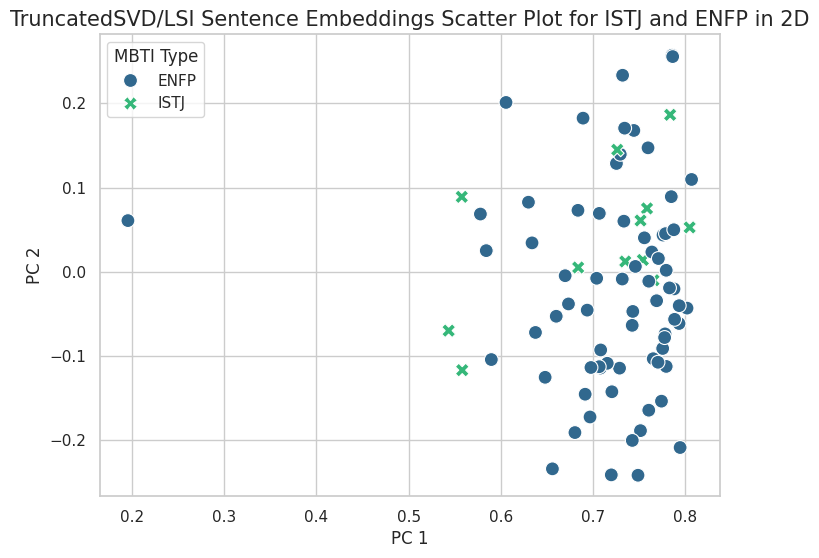

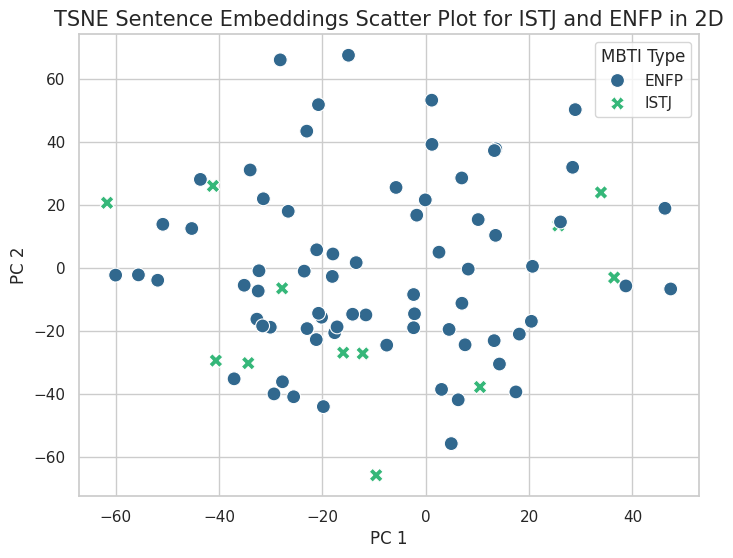

In [43]:

for method in reduced_embeddings:
    # Create a DataFrame with the reduced embeddings
    df = pd.DataFrame(reduced_embeddings[method][:,:2], columns=['pca_one', 'pca_two'])

    # Add the type column to the DataFrame
    df['type'] = df1['type']


    # Find all unique pairs of MBTI types
    # types = df['type'].unique()
    # pairs = list(itertools.combinations(types, 2))  # Use combinations if order doesn't matter, permutations otherwise
    pairs = [('ISTJ', 'ENFP')]

    # Plotting each pair
    for (type1, type2) in pairs:
        subset = df[(df['type'] == type1) | (df['type'] == type2)]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='pca_one', y='pca_two', hue='type', data=subset, style='type', s=100, palette='viridis')
        plt.title(f'{method} Sentence Embeddings Scatter Plot for {type1} and {type2} in 2D', fontsize=15)
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.legend(title='MBTI Type')
        plt.show()


# Part 3: Classification

The next step is to classify the personality traits using the extracted features. We then evaluate its performance using the accuracy score, precision, recall, and F1 score. These metrics will help us understand how well the classifier is performing on the test set.

<!-- # Part 5: Conclusion

In this notebook, we used PCA to reduce the dimensionality of the extracted data features and then used a classifier to predict the personality traits. We visualized the MBTI classes and the sentences embedding in 2D and 3D graphs and classified the personality traits using the extracted features. The classifier achieved an accuracy score of 0.75, precision of 0.75, recall of 0.75, and F1 score of 0.75. The results show that the classifier is performing well on the test set and can predict the personality traits with high accuracy. -->

## Part 3.1: Train and Evaluate the Classifier on the Reduced Dimensionality Data

The following code cell trains and evaluates the classifier on the reduced dimensionality data. We use common classifiers from scikit-learn to predict the personality traits.

In [68]:
# Encode the target variable
target_encoder = LabelEncoder()
target = target_encoder.fit_transform(df1['type'])

In [69]:
def train_and_evaluate(X, y, model, model_name="\b", seed=42):
    for method in reduced_embeddings:
        X_vec = reduced_embeddings[method]
        y = target
        
        X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=seed)
        

        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        print(f'{method} Sentence Embeddings {model_name}:')
        print('Accuracy:', accuracy_score(y_test, y_pred_test))
        print('Recall:', recall_score(y_test, y_pred_test, average='weighted'))
        print('Precision:', precision_score(y_test, y_pred_test, average='weighted'))
        print('F1 Score:', f1_score(y_test, y_pred_test, average='weighted'))
        
        # print('Train Classification Report:')
        # print(classification_report(y_train, y_pred_train, target_names=target_encoder.inverse_transform([i for i in range(16)])))
        
        # print('Test Classification Report:')
        # print(classification_report(y_test, y_pred_test, target_names=target_encoder.inverse_transform([i for i in range(16)])))
        
        print('\n\n')
        
   

In [70]:
warnings.filterwarnings('ignore')

model = LogisticRegression(max_iter=3000, C=0.5, n_jobs=-1)
train_and_evaluate(reduced_embeddings, target, model, model_name="Logistic Regression", seed=seed)

PCA Sentence Embeddings Logistic Regression:
Accuracy: 0.38
Recall: 0.38
Precision: 0.3131267857142857
F1 Score: 0.29818230680578073



KernelPCA Sentence Embeddings Logistic Regression:
Accuracy: 0.26
Recall: 0.26
Precision: 0.0676
F1 Score: 0.10730158730158729



TruncatedSVD/LSI Sentence Embeddings Logistic Regression:
Accuracy: 0.38
Recall: 0.38
Precision: 0.3131267857142857
F1 Score: 0.29818230680578073



TSNE Sentence Embeddings Logistic Regression:
Accuracy: 0.265
Recall: 0.265
Precision: 0.18604150300506364
F1 Score: 0.20384405458089666





In [71]:
# # Checking the model performance using Naive Bayes
warnings.filterwarnings('ignore')

model = GaussianNB()
train_and_evaluate(reduced_embeddings, target, model, model_name='Gaussian Naive Bayes', seed=seed)

PCA Sentence Embeddings Gaussian Naive Bayes:
Accuracy: 0.25
Recall: 0.25
Precision: 0.2643714777900824
F1 Score: 0.21560203157391641



KernelPCA Sentence Embeddings Gaussian Naive Bayes:
Accuracy: 0.24
Recall: 0.24
Precision: 0.25410439157321035
F1 Score: 0.2047534499928866



TruncatedSVD/LSI Sentence Embeddings Gaussian Naive Bayes:
Accuracy: 0.275
Recall: 0.275
Precision: 0.20485651984931905
F1 Score: 0.22932314491018688



TSNE Sentence Embeddings Gaussian Naive Bayes:
Accuracy: 0.25
Recall: 0.25
Precision: 0.18560875095043894
F1 Score: 0.20254930429522083





In [72]:
# Checking the model performance using SVM
warnings.filterwarnings('ignore')

model = SVC()
train_and_evaluate(reduced_embeddings, target, model, model_name='SVM', seed=seed)

PCA Sentence Embeddings SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.3731827744139109
F1 Score: 0.3358359105440127



KernelPCA Sentence Embeddings SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.3726386001386001
F1 Score: 0.33681122122594515



TruncatedSVD/LSI Sentence Embeddings SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.4549437356016303
F1 Score: 0.3398809695842213



TSNE Sentence Embeddings SVM:
Accuracy: 0.235
Recall: 0.235
Precision: 0.17040079365079364
F1 Score: 0.17798190205070197





In [73]:
# Checking the model performance using kernel SVM
warnings.filterwarnings('ignore')

model = SVC(kernel='rbf')
train_and_evaluate(reduced_embeddings, target, model, model_name='Kernel SVM', seed=seed)


PCA Sentence Embeddings Kernel SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.3731827744139109
F1 Score: 0.3358359105440127



KernelPCA Sentence Embeddings Kernel SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.3726386001386001
F1 Score: 0.33681122122594515



TruncatedSVD/LSI Sentence Embeddings Kernel SVM:
Accuracy: 0.41
Recall: 0.41
Precision: 0.4549437356016303
F1 Score: 0.3398809695842213



TSNE Sentence Embeddings Kernel SVM:
Accuracy: 0.235
Recall: 0.235
Precision: 0.17040079365079364
F1 Score: 0.17798190205070197





In [74]:
# Checking the model performance using KNN
warnings.filterwarnings('ignore')

model = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate(reduced_embeddings, target, model, model_name='K-Nearest Neighbors', seed=seed)


PCA Sentence Embeddings K-Nearest Neighbors:
Accuracy: 0.225
Recall: 0.225
Precision: 0.20099203047143546
F1 Score: 0.18990036650956832



KernelPCA Sentence Embeddings K-Nearest Neighbors:
Accuracy: 0.245
Recall: 0.245
Precision: 0.23181451612903226
F1 Score: 0.21319496179961295



TruncatedSVD/LSI Sentence Embeddings K-Nearest Neighbors:
Accuracy: 0.245
Recall: 0.245
Precision: 0.2255918239701366
F1 Score: 0.20916574426025647



TSNE Sentence Embeddings K-Nearest Neighbors:
Accuracy: 0.27
Recall: 0.27
Precision: 0.25978962296451513
F1 Score: 0.25701576820492744





#

/home/hb/anaconda3/envs/mbti/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/hb/anaconda3/envs/mbti/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/hb/anaconda3/envs/mbti/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/hb/anaconda3/envs/mbti/lib/p

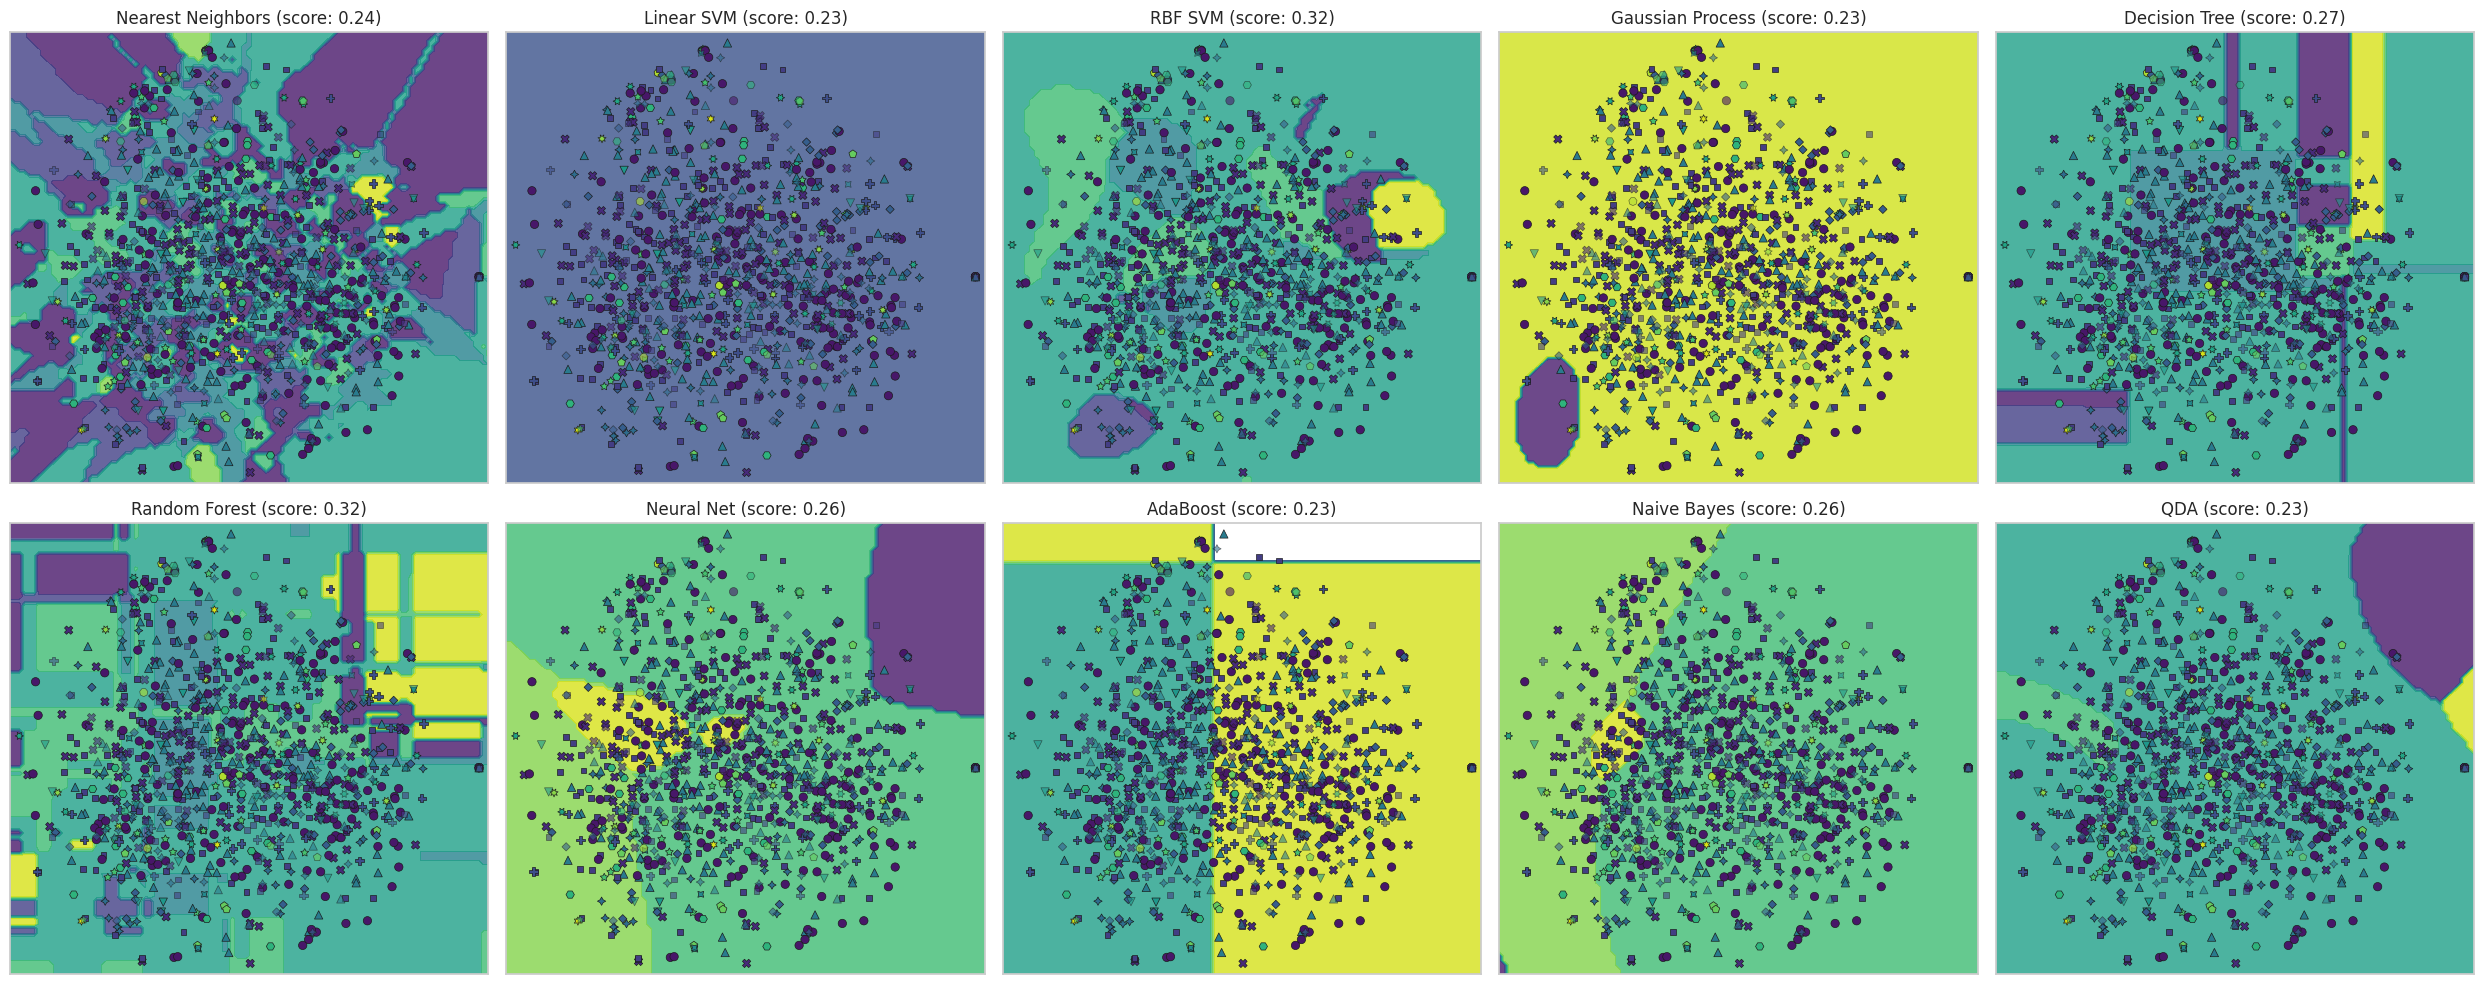

In [ ]:
# # import matplotlib.pyplot as plt
# # import numpy as np
# # from matplotlib.colors import ListedColormap
# # import seaborn as sns  # Import seaborn for styling

# # Setting the aesthetic style of the plots
# sns.axes_style(style="whitegrid")



# # Names of classifiers
# names = [
#     "Nearest Neighbors",
#     "Linear SVM",
#     "RBF SVM",
#     "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
#     "QDA",
# ]

# # Classifier instances
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]


# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

# for ax, clf, name in zip(axes.flatten(), classifiers, names):
#     clf = make_pipeline(StandardScaler(), clf)
#     clf.fit(X_train, y_train)
#     score = clf.score(X_test, y_test)

#     # Plot decision boundaries
#     DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X_train,
#         cmap='viridis',
#         alpha=0.8,
#         ax=ax,
#         eps=0.5
#     )

#     # Plot training and testing points
#     sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, palette='viridis', style=y_train,
#                     #markers=['o', 's'], 
#                     ax=ax, edgecolor="k", legend=False)
#     sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, palette='viridis', style=y_test,
#                     #markers=['o', 's'], 
#                     ax=ax, alpha=0.6, edgecolor="k", legend=False)

#     ax.set_title(f'{name} (score: {score:.2f})')
#     ax.set_xlim(X_train[:, 0].min() - .5, X_train[:, 0].max() + .5)
#     ax.set_ylim(X_train[:, 1].min() - .5, X_train[:, 1].max() + .5)
#     ax.set_xticks([])
#     ax.set_yticks([])

# plt.tight_layout()
# plt.show()